# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Мы хотим проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Изучение данных

In [1]:
# Библиотека для работы с таблицами
import pandas as pd

# инструменты визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# Инструменты моделирования
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Для бутстрепа
import numpy as np

# Проверим признаки на корреляцию
! pip install phik
import phik
from phik import resources, report

     -------------------------------------- 663.5/663.5 kB 3.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df1 = pd.read_csv('~/oil_production/geo_data_0.csv')
df2 = pd.read_csv('~/oil_production/geo_data_1.csv')
df3 = pd.read_csv('~/oil_production/geo_data_2.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


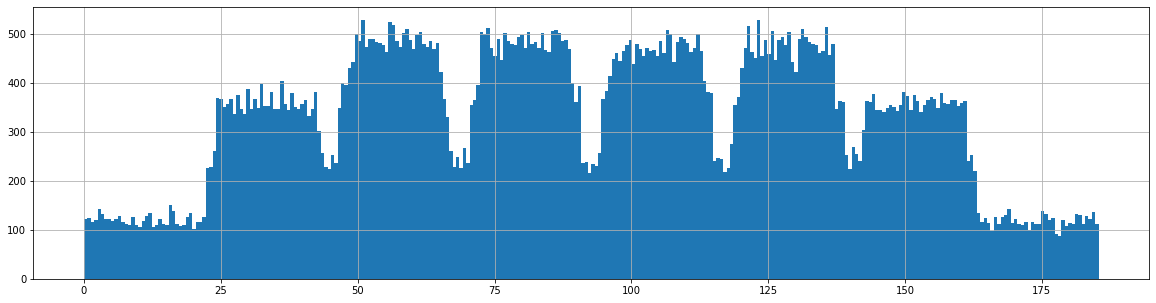

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [3]:
display(df1.head())
print(df1.info())
df1['product'].hist(figsize=(20, 5), bins=300, grid=True)
plt.show()
df1.describe()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


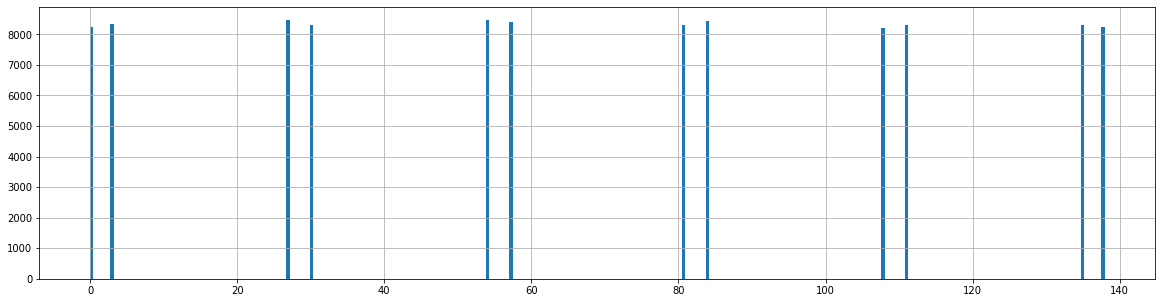

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [5]:
display(df2.head())
print(df2.info())
df2['product'].hist(figsize=(20, 5), bins=300, grid=True)
plt.show()
df2.describe()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


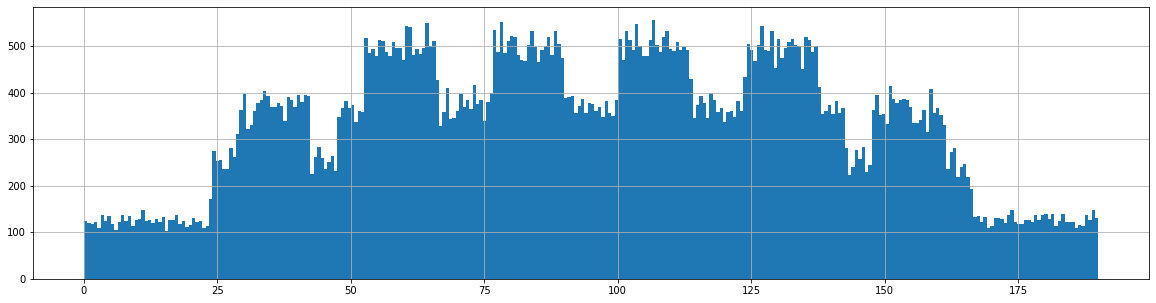

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
display(df3.head())
print(df3.info())
df3['product'].hist(figsize=(20, 5), bins=300, grid=True)
plt.show()
df3.describe()

Данные выглядят странно, есть предположение, что их объем сгенерирован с помощью семплирования, особенно это отражается на данных df2.

### Корреляция признаков

Посмотрим корреляционную матрицу датасетов на момент корреляции признаков и целевого значения.

Регион 1 - df1

In [7]:
# Выделим признаки для расчета
interval_cols = ['f0' ,'f1' ,'f2' ,'product']
phik_overview = df1.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,f0,f1,f2,product
f0,1.00,0.76,0.00,0.22
f1,0.76,1.00,0.00,0.25
f2,0.00,0.00,1.00,0.48
product,0.22,0.25,0.48,1.00


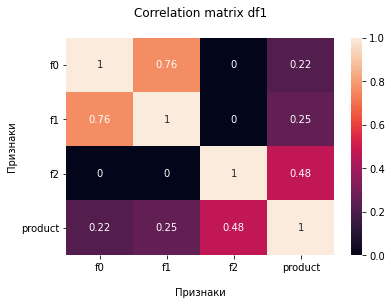

In [8]:
# Строим матрицу корреляции
plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Correlation matrix df1\n")
plt.yticks(rotation=0)
plt.show()

Регион 2 - df2

In [9]:
interval_cols = ['f0' ,'f1' ,'f2' ,'product']
phik_overview = df2.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,f0,f1,f2,product
f0,1.00,0.20,0.00,0.63
f1,0.20,1.00,0.00,0.19
f2,0.00,0.00,1.00,0.98
product,0.63,0.19,0.98,1.00


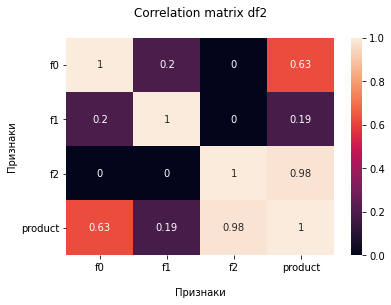

In [10]:
plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Correlation matrix df2\n")
plt.yticks(rotation=0)
plt.show()

Регион 3 - df3

In [11]:
interval_cols = ['f0' ,'f1' ,'f2' ,'product']
phik_overview = df3.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,f0,f1,f2,product
f0,1.0,0.00,0.00,0.20
f1,0.0,1.00,0.00,0.22
f2,0.0,0.00,1.00,0.44
product,0.2,0.22,0.44,1.00


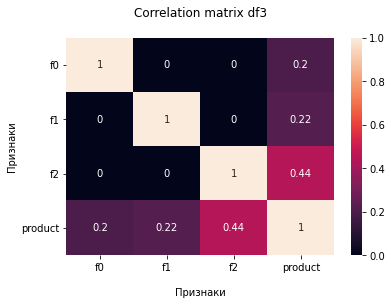

In [12]:
plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Correlation matrix df3\n")
plt.yticks(rotation=0)
plt.show()

Наиболее высокую корреляцию с целевым признаков во всех датасетах показывает признак f2, модель в своих выводах будет оприраться прежде всего на него, но в связи с отсутствием информации о признаке, мы не можем его удалить.

### Масштабирование и деление на выборки

Разброс у данных небольшой, но их всё рабно рекомендуется масштабировать

In [13]:
# разделим датасеты на обучающую и валидационную выборки
# сохраним их в списки
targets_train_list = []
features_train_list = []
targets_valid_list = []
features_valid_list = []

# распределять будем посредством цикла
for i in [df1, df2, df3]:
    features = i.drop(['id', 'product'], axis=1)
    target = i['product']
    
    # Разделим данные на выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25,
                                                                               random_state=12345)
    
    # попутно масштабируем признаки
    scaler = StandardScaler()
    features_scaled_train = scaler.fit_transform(features_train)    
    features_scaled_valid = scaler.transform(features_valid)

    targets_train_list.append(target_train)
    features_train_list.append(features_scaled_train)
    targets_valid_list.append(target_valid)
    features_valid_list.append(features_scaled_valid)

## Обучение и проверка модели

По условию задачи используем линейную регрессию

In [14]:
# Для удобного хранения моделей прогнозов и оценок используем списки
models_list = []
predict_list = []
rmse_list = []
mean_crude = []
mean_crude_target=[]
# Циклом переберём датафреймы
for i in range(len(features_train_list)):
    model = LinearRegression()
        
    model.fit(features_train_list[i], targets_train_list[i])
     
    prediction = model.predict(features_valid_list[i])
    mse = mean_squared_error(targets_valid_list[i], prediction)
    # Запись в списки
    predict_list.append(prediction)
    rmse_list.append(mse**0.5)
    mean_crude.append(pd.Series(prediction).mean()) 
    mean_crude_target.append(pd.Series(targets_valid_list[i]).mean())

In [15]:
table_results = pd.DataFrame(pd.concat([pd.Series(rmse_list), pd.Series(mean_crude), pd.Series(mean_crude_target)], axis=1).T, 
                            index=['rmse', 'mean_pred', 'mean_target'], columns=['df1', 'df2', 'df3'])
table_results

,df1,df2,df3
rmse,NaN,NaN,NaN
mean_pred,NaN,NaN,NaN
mean_target,NaN,NaN,NaN


Странная ошибка при построении таблицы, причина мне неизвестна, поэтому сделаем так:

In [16]:
# строим датафрейм с обобщенными результатами работы
table_results = pd.DataFrame(pd.concat([pd.Series(rmse_list), pd.Series(mean_crude), pd.Series(mean_crude_target)], axis=1).T)
table_results.index = ['rmse', 'mean_pred', 'mean_target']
table_results.columns = ['df1', 'df2', 'df3']
table_results

,df1,df2,df3
rmse,37.579422,0.893099,40.029709
mean_pred,92.592568,68.728547,94.965046
mean_target,92.078597,68.723136,94.884233


В среднем модель линейной регрессии ошибается:
- В первом регионе на 37 тыс. баррелей
- Во втором регионе на 893 барреля
- В регионе три на 40 тыс баррелей

Наиболее богатым регионом является регион №1, следом идут №3 и №2. Для разработки предлагается регион №3, как в среднем наиболее богатый недрами, что подбверждает предсказание модели.

## Подготовка к расчёту прибыли

Расчитаем достаточный объем сырья для безубыточной разработки скважины.

In [17]:
value_crude = 10000000 / 200 / 450
value_crude

111.11111111111111

Для безубыточной добычи необходимо разрабатывать скважины объемом свыше 111 тыс. баррелей. Однако данные по составу затрат недоступны, сюда входит содержание персонала, аммортизация, логистика и тд. Не ясно, 10 млрд. на 200 скважин это траты на разработку или разработку и последующую эксплуатацию.

Посчитаем средний объем скважин в регионе исходя из прогноза.

In [18]:
print(pd.Series(predict_list[0]).mean())
print(pd.Series(predict_list[1]).mean())
print(pd.Series(predict_list[2]).mean())

92.59256778438035
68.728546895446
94.96504596800489


Средний показатель по регионам ниже точнки безубыточности, разработка некоторых скважин нерентабельна, в связи с этим принято решение разрабатывать 200 наиболее богатых месторождений.

Переменные для функции расчета прибыли

In [19]:
# тыс. рублей
COSTS = 10000000
QUANTITY = 200
BARREL = 450

## Расчёт прибыли и рисков 

In [20]:
# переведу результаты в сериесы для использования методов pandas
for i in range(len(targets_valid_list)):
    targets_valid_list[i] = pd.Series(targets_valid_list[i])
    predict_list[i] = pd.Series(predict_list[i])

In [21]:
# топ 200 из 500 случайных
def top_200 (target, predict):
    
    top_predict = predict.sort_values(ascending=False).head(200)
    top_target = target.iloc[top_predict.index]
    
    return top_predict, top_target

In [22]:
# подсчёт общей прибыли из случйно выбоки
def mid_profit (target, costs, barrel):
    return (target * barrel - costs / len(target)).sum()

In [23]:
# Рандом для рандомстейта
state = np.random.RandomState(12345)

values_table = []
# Бутстреп на 1000 выборок
for i in range(len(predict_list)):
    values = []
    for j in range(1000):
        subsample_predict = predict_list[i].sample(n=500, replace=True, random_state=state)
                
        predict_200, target_200 = top_200(targets_valid_list[i], subsample_predict)
        
        mid_region_profit = mid_profit(target_200, COSTS, BARREL)
        
        # Сохраняем данные в промежуточный список
        values.append(mid_region_profit)
# Сохраняем итог
    values_table.append(values)
        

bootstrap = pd.DataFrame(values_table, index=['df1', 'df2', 'df3']).T

In [24]:
# Итоговый датафрейм
bootstrap = pd.DataFrame([bootstrap.mean(), bootstrap.quantile(0.975), bootstrap.quantile(0.025), \
                         bootstrap[bootstrap < 0].count() / bootstrap.shape[0]],
                         index=['Средняя прибыль', '0.975', '0.025', 'Доля убыточных кейсов'])
bootstrap

,df1,df2,df3
Средняя прибыль,396164.984802,461155.817277,392950.475171
0.975,909766.941553,862952.060264,934562.914551
0.025,-111215.545890,78050.810752,-112227.625379
Доля убыточных кейсов,0.069000,0.007000,0.065000


По прогнозу модели, самым прибыльным окажется регион №3. При этом он имеет 6,5% убыточных кейсов.

Исходя из предсказания модели, для разработки наиболее предпочтителен регион №3. С вероятностью 95% при реализации проекта мы получим до 934 млн. рублей, но при этом есть риск убытков при составлении неправильного кейса скважин, вероятность этого 6,5%. Наименьший риск имеет регион №2, при этом в худшем случае мы получим 78 млн. рублей, рекомендуется диверсифицировать проекты и часть скважин оствоить в регионе №1.

Исходя из условий задачи выбираем регион №2 с показателем риска убытков ниже 2.5%